[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

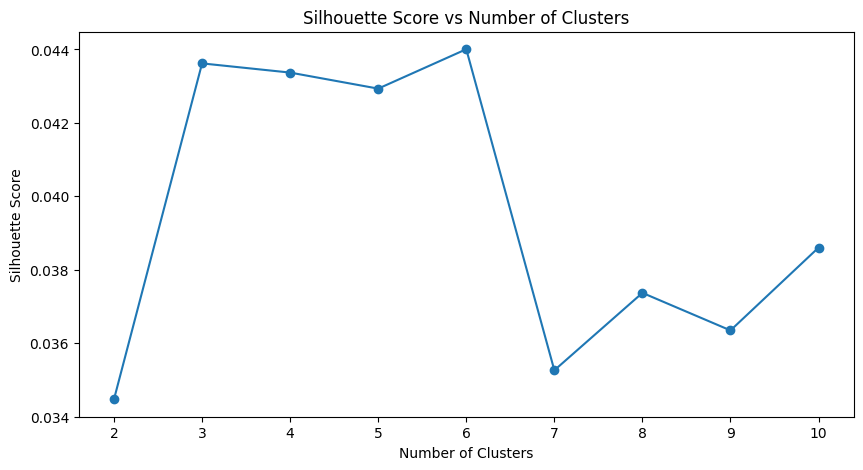

Silhouette Score: 0.044005244970321655

Cluster Distribution:
cluster
0    211
1    171
2    153
3    228
4    128
5    185
Name: text, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

class TextClusterer:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        """
        Initialize the text clustering pipeline

        Args:
            model_name (str): Sentence transformer model name
        """
        self.stop_words = set(stopwords.words('english'))
        self.porter_stemmer = PorterStemmer()
        self.wordnet_lemmatizer = WordNetLemmatizer()
        self.sbert_model = SentenceTransformer(model_name)

    def preprocess_text(self, text):
        """
        Preprocess text by cleaning and normalizing

        Args:
            text (str): Input text

        Returns:
            str: Cleaned and normalized text
        """
        text = str(text).lower()
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove digits
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_and_clean(self, text):
        """
        Tokenize text and remove stopwords

        Args:
            text (str): Input text

        Returns:
            list: Cleaned tokens
        """
        tokens = text.split()
        tokens = [
            token for token in tokens
            if token.lower() not in self.stop_words
        ]
        return tokens

    def stem_tokens(self, tokens):
        """
        Apply stemming to tokens

        Args:
            tokens (list): Input tokens

        Returns:
            list: Stemmed tokens
        """
        return [self.porter_stemmer.stem(token) for token in tokens]

    def lemmatize_tokens(self, tokens):
        """
        Apply lemmatization to tokens

        Args:
            tokens (list): Input tokens

        Returns:
            list: Lemmatized tokens
        """
        return [self.wordnet_lemmatizer.lemmatize(token) for token in tokens]

    def process_dataframe(self, df, text_column='text'):
        """
        Process entire DataFrame for clustering

        Args:
            df (pd.DataFrame): Input DataFrame
            text_column (str): Name of text column

        Returns:
            pd.DataFrame: Processed DataFrame
        """
        # Clean text
        df['clean_text'] = df[text_column].apply(self.preprocess_text)

        # Tokenize and remove stopwords
        df['tokens'] = df['clean_text'].apply(self.tokenize_and_clean)

        # Stem and lemmatize
        df['stemmed_tokens'] = df['tokens'].apply(self.stem_tokens)
        df['lemmatized_tokens'] = df['tokens'].apply(self.lemmatize_tokens)

        # Generate embeddings
        df['bert_vector'] = list(self.sbert_model.encode(df['clean_text'].tolist()))

        return df

    def find_optimal_clusters(self, embeddings, max_clusters=10):
        """
        Find optimal number of clusters using silhouette score

        Args:
            embeddings (np.array): Embeddings matrix
            max_clusters (int): Maximum number of clusters to try

        Returns:
            int: Optimal number of clusters
        """
        silhouette_scores = []

        for n_clusters in range(2, max_clusters + 1):
            kmeans = KMeans(
                n_clusters=n_clusters,
                n_init=10,
                random_state=42
            )
            cluster_labels = kmeans.fit_predict(embeddings)
            score = silhouette_score(embeddings, cluster_labels)
            silhouette_scores.append(score)

        # Plot silhouette scores
        plt.figure(figsize=(10, 5))
        plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
        plt.title('Silhouette Score vs Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

        # Return cluster count with highest silhouette score
        return silhouette_scores.index(max(silhouette_scores)) + 2

    def cluster_data(self, df, n_clusters=None):
        """
        Perform K-means clustering

        Args:
            df (pd.DataFrame): Processed DataFrame
            n_clusters (int, optional): Number of clusters

        Returns:
            pd.DataFrame: DataFrame with cluster assignments
        """
        # Extract embeddings
        embeddings = np.array(df['bert_vector'].tolist())

        # Scale embeddings
        scaler = StandardScaler()
        scaled_embeddings = scaler.fit_transform(embeddings)

        # Find optimal clusters if not specified
        if n_clusters is None:
            n_clusters = self.find_optimal_clusters(scaled_embeddings)

        # Perform clustering
        kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=10,
            random_state=42
        )
        df['cluster'] = kmeans.fit_predict(scaled_embeddings)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(scaled_embeddings, df['cluster'])
        print(f"Silhouette Score: {silhouette_avg}")

        return df

# Example usage
def main():
    # Load data
    df = pd.read_csv('/content/people_wiki.csv')

    # Initialize clusterer
    clusterer = TextClusterer()

    # Process data
    processed_df = clusterer.process_dataframe(df)

    # Cluster data
    clustered_df = clusterer.cluster_data(processed_df)

    # Optional: Analyze clusters
    cluster_summary = clustered_df.groupby('cluster')['text'].count()
    print("\nCluster Distribution:")
    print(cluster_summary)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


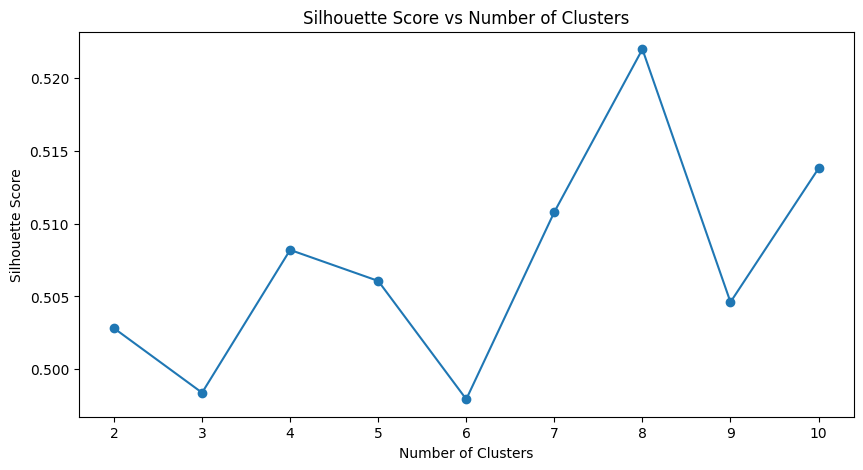

Silhouette Score: 0.5219868421554565

Cluster Distribution:
cluster
0    2497
1    3531
2    2908
3    2953
4    1760
5    2580
6    1266
7    1273
Name: text, dtype: int64

Cluster 2 Sample:
0     digby morrell born 10 october 1979 is a former...
17    paddy dunne was a gaelic football player from ...
21    ceiron thomas born 23 october 1983 is a welsh ...
Name: text, dtype: object

Cluster 1 Sample:
1    alfred j lewy aka sandy lewy graduated from un...
5    sam henderson born october 18 1969 is an ameri...
7    trevor ferguson aka john farrow born 11 novemb...
Name: text, dtype: object

Cluster 3 Sample:
2    harpdog brown is a singer and harmonica player...
4    henry krvits born 30 december 1974 in tallinn ...
6    aaron lacrate is an american music producer re...
Name: text, dtype: object

Cluster 5 Sample:
3     franz rottensteiner born in waidmannsfeld lowe...
9     cathy caruth born 1955 is frank h t rhodes pro...
16    fr andrew pinsent born 19 august 1966 is resea...
Name: t

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

class AdvancedTextClustering:
    def __init__(self, n_topics=10, clustering_method='kmeans'):
        """
        Initialize advanced text clustering pipeline

        Args:
            n_topics (int): Number of topics for LDA
            clustering_method (str): Clustering method ('kmeans' or 'dbscan')
        """
        self.stop_words = set(stopwords.words('english'))
        self.n_topics = n_topics
        self.clustering_method = clustering_method

    def preprocess_text(self, text):
        """
        Comprehensive text preprocessing

        Args:
            text (str): Input text

        Returns:
            str: Cleaned text
        """
        # Convert to lowercase
        text = str(text).lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and short words
        tokens = [
            token for token in tokens
            if token not in self.stop_words and len(token) > 2
        ]

        return ' '.join(tokens)

    def extract_topics(self, processed_texts):
        """
        Extract topics using Latent Dirichlet Allocation

        Args:
            processed_texts (list): List of preprocessed texts

        Returns:
            np.array: Topic distribution matrix
        """
        # Create document-term matrix
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
        doc_term_matrix = vectorizer.fit_transform(processed_texts)

        # Apply LDA
        lda_model = LatentDirichletAllocation(
            n_components=self.n_topics,
            random_state=42,
            learning_method='online'
        )
        topic_dist = lda_model.fit_transform(doc_term_matrix)

        return topic_dist

    def apply_dimensionality_reduction(self, features, method='umap'):
        """
        Reduce dimensionality of features

        Args:
            features (np.array): Input features
            method (str): Dimensionality reduction method

        Returns:
            np.array: Reduced dimensionality features
        """
        if method == 'umap':
            reducer = umap.UMAP(n_components=5, random_state=42)
        else:
            reducer = PCA(n_components=5, random_state=42)

        return reducer.fit_transform(features)

    def cluster_texts(self, topic_dist):
        """
        Cluster texts based on topic distribution

        Args:
            topic_dist (np.array): Topic distribution matrix

        Returns:
            tuple: Cluster labels and silhouette score
        """
        # Scale features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(topic_dist)

        # Reduce dimensionality
        reduced_features = self.apply_dimensionality_reduction(scaled_features)

        # Clustering
        if self.clustering_method == 'dbscan':
            # DBSCAN clustering
            dbscan = DBSCAN(eps=0.5, min_samples=5)
            clusters = dbscan.fit_predict(reduced_features)

            # If DBSCAN doesn't create multiple clusters, fallback to KMeans
            if len(set(clusters)) <= 1:
                print("DBSCAN failed to create multiple clusters. Falling back to KMeans.")
                kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
                clusters = kmeans.fit_predict(reduced_features)

        else:
            # KMeans clustering with optimal cluster determination
            silhouette_scores = []
            max_clusters = 10

            for n_clusters in range(2, max_clusters + 1):
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                cluster_labels = kmeans.fit_predict(reduced_features)

                # Compute silhouette score
                try:
                    score = silhouette_score(reduced_features, cluster_labels)
                    silhouette_scores.append(score)
                except Exception:
                    silhouette_scores.append(-1)

            # Find optimal number of clusters
            optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

            # Visualize silhouette scores
            plt.figure(figsize=(10, 5))
            plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
            plt.title('Silhouette Score vs Number of Clusters')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Silhouette Score')
            plt.show()

            # Perform clustering with optimal clusters
            kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(reduced_features)

        # Compute silhouette score
        try:
            sil_score = silhouette_score(reduced_features, clusters)
            print(f"Silhouette Score: {sil_score}")
        except Exception as e:
            print(f"Could not compute silhouette score: {e}")
            sil_score = None

        return clusters, sil_score

    def process_and_cluster(self, dataframe, text_column='text'):
        """
        Main method to process and cluster texts

        Args:
            dataframe (pd.DataFrame): Input DataFrame
            text_column (str): Name of text column

        Returns:
            pd.DataFrame: DataFrame with cluster assignments
        """
        # Preprocess texts
        dataframe['processed_text'] = dataframe[text_column].apply(self.preprocess_text)

        # Extract topics
        topic_dist = self.extract_topics(dataframe['processed_text'])

        # Cluster texts
        clusters, sil_score = self.cluster_texts(topic_dist)

        # Add cluster labels to DataFrame
        dataframe['cluster'] = clusters

        return dataframe

# Example usage
def main():
    # Load dataset
    df = pd.read_csv('/content/people_wiki.csv')

    # Initialize clustering
    clusterer = AdvancedTextClustering(
        n_topics=10,  # Adjust number of topics
        clustering_method='kmeans'  # or 'dbscan'
    )

    # Process and cluster
    clustered_df = clusterer.process_and_cluster(df)

    # Analyze clusters
    cluster_summary = clustered_df.groupby('cluster')['text'].count()
    print("\nCluster Distribution:")
    print(cluster_summary)

    # Optional: Print sample texts from each cluster
    for cluster in clustered_df['cluster'].unique():
        print(f"\nCluster {cluster} Sample:")
        print(clustered_df[clustered_df['cluster'] == cluster]['text'].head(3))

if __name__ == "__main__":
    main()

In [ ]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True